In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os
import pickle

from scipy.signal import sosfilt, zpk2sos, iirfilter,welch, decimate

In [3]:
drypath = "/Volumes/T7/datasets/MIT_AE/Dry/"
wetpath = "/Volumes/T7/datasets/MIT_AE/Wet/"

In [3]:
mech_dry_data = {}

with h5py.File(os.path.join(drypath,"mechanicalData_Dry.h5")) as f:
    print(f.keys())
    for key in f.keys():
        mech_dry_data[key] = f[key][()]

<KeysViewHDF5 ['Date', 'Disp_mm', 'P_conf_MPa', 'P_pore_MPa', 'RockType', 'SampleDiameter_mm', 'SampleLength_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 't_def_hr']>


In [4]:
mech_dry_data["Date"]

b'2019Dec03'

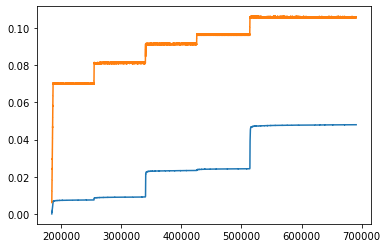

In [5]:
plt.plot(mech_dry_data["t_def"].flatten(), mech_dry_data["Strain_ax"].flatten())
plt.plot(mech_dry_data["t_def"].flatten(), mech_dry_data["Sig_diff_MPa"].flatten()/1000)

In [6]:
tdef0 = 0

In [3]:
waveforms = []
catalog = pd.DataFrame()

with h5py.File(os.path.join(drypath, "data_Dry_AEs.h5")) as f:
    print(f.keys())
    print(f["catalog"].keys())
    for key in f["catalog"].keys():
        catalog[key] = f[f"catalog/{key}"][()]
    print(f["catalog/datetime"])
    #print(f["waveforms"]["pzt01"]["ch01"].keys())
    evids = list(f["waveforms"]["pzt01"]["ch01"].keys())
    for id in evids:
        waveforms.append(f[f"waveforms/pzt01/ch01/{id}"][()])


<KeysViewHDF5 ['catalog', 'processing_info', 'spec_parameters', 'waveforms']>
<KeysViewHDF5 ['datetime', 'day', 'depth', 'event_ID', 'event_ID_orig', 'hour', 'lat', 'long', 'mag', 'minute', 'month', 'second', 'year']>
<HDF5 dataset "datetime": shape (5471,), type "|S48">


In [162]:
specnames = []
specs = []

with h5py.File(os.path.join(drypath, "data_Dry_AEs.h5_Sgrams_Subcatalog.hdf5")) as f:
    print(f.keys())
    for key in f["sgrams"].keys():
        specs.append(f["sgrams"][key][:])


<KeysViewHDF5 ['sgram_normConst', 'sgrams']>


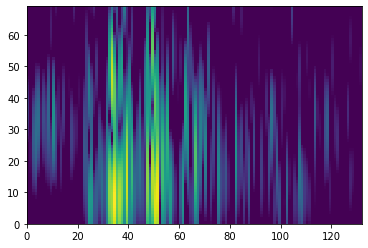

In [170]:
plt.pcolormesh(specs[6])

In [8]:
## Pull out waveformns and times, match times to stress, displacement, strain
## Train on those

catalog

,datetime,day,depth,event_ID,event_ID_orig,hour,lat,long,mag,minute,month,second,year
0,b'2020-01-08T15:32:41.506000000',7,1.0,b'2020.008.393241.142361506',b'142361506',39,1.0,1.0,1.0,32,1,41.506,2020
1,b'2020-01-08T15:54:05.590000000',7,1.0,b'2020.008.395405.143645590',b'143645590',39,1.0,1.0,1.0,54,1,5.590,2020
2,b'2020-01-08T16:25:57.856000000',7,1.0,b'2020.008.402557.145557856',b'145557856',40,1.0,1.0,1.0,25,1,57.856,2020
3,b'2020-01-08T16:30:57.607000000',7,1.0,b'2020.008.403057.145857607',b'145857607',40,1.0,1.0,1.0,30,1,57.607,2020
4,b'2020-01-08T16:54:42.610000000',7,1.0,b'2020.008.405442.147282610',b'147282610',40,1.0,1.0,1.0,54,1,42.610,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5466,b'2020-01-15T06:38:26.760000000',7,1.0,b'2020.015.1983826.715106760',b'715106760',198,1.0,1.0,1.0,38,1,26.760,2020
5467,b'2020-01-15T07:06:36.490000000',7,1.0,b'2020.015.1990636.716796490',b'716796490',199,1.0,1.0,1.0,6,1,36.490,2020
5468,b'2020-01-15T07:06:38.597000000',7,1.0,b'2020.015.1990638.716798597',b'716798597',199,1.0,1.0,1.0,6,1,38.597,2020
5469,b'2020-01-15T07:25:45.520000000',7,1.0,b'2020.015.1992545.717945520',b'717945520',199,1.0,1.0,1.0,25,1,45.520,2020


In [9]:
catalog["datetime"] = pd.to_datetime(catalog["datetime"].apply(lambda x: x.decode("utf-8")))
catalog["event_ID"] = catalog["event_ID"].apply(lambda x: x.decode("utf-8"))
catalog["event_ID_orig"] = catalog["event_ID_orig"].apply(lambda x: x.decode("utf-8"))

In [10]:
catalog

,datetime,day,depth,event_ID,event_ID_orig,hour,lat,long,mag,minute,month,second,year
0,2020-01-08 15:32:41.506,7,1.0,2020.008.393241.142361506,142361506,39,1.0,1.0,1.0,32,1,41.506,2020
1,2020-01-08 15:54:05.590,7,1.0,2020.008.395405.143645590,143645590,39,1.0,1.0,1.0,54,1,5.590,2020
2,2020-01-08 16:25:57.856,7,1.0,2020.008.402557.145557856,145557856,40,1.0,1.0,1.0,25,1,57.856,2020
3,2020-01-08 16:30:57.607,7,1.0,2020.008.403057.145857607,145857607,40,1.0,1.0,1.0,30,1,57.607,2020
4,2020-01-08 16:54:42.610,7,1.0,2020.008.405442.147282610,147282610,40,1.0,1.0,1.0,54,1,42.610,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5466,2020-01-15 06:38:26.760,7,1.0,2020.015.1983826.715106760,715106760,198,1.0,1.0,1.0,38,1,26.760,2020
5467,2020-01-15 07:06:36.490,7,1.0,2020.015.1990636.716796490,716796490,199,1.0,1.0,1.0,6,1,36.490,2020
5468,2020-01-15 07:06:38.597,7,1.0,2020.015.1990638.716798597,716798597,199,1.0,1.0,1.0,6,1,38.597,2020
5469,2020-01-15 07:25:45.520,7,1.0,2020.015.1992545.717945520,717945520,199,1.0,1.0,1.0,25,1,45.520,2020


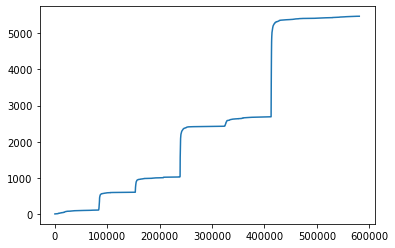

In [11]:
plt.plot((catalog["datetime"] - catalog.iloc[0]["datetime"])*1e-9, catalog["month"].cumsum())

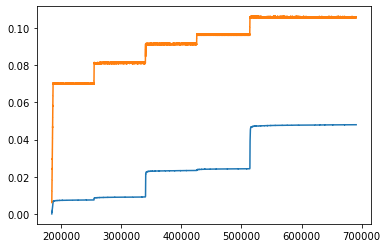

In [12]:
plt.plot(mech_dry_data["t_def"].flatten(), mech_dry_data["Strain_ax"].flatten())
plt.plot(mech_dry_data["t_def"].flatten(), mech_dry_data["Sig_diff_MPa"].flatten()/1000)

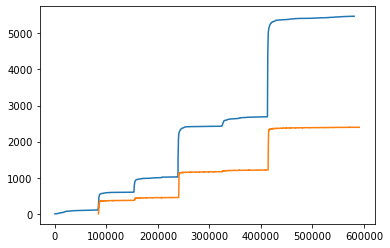

In [13]:
plt.plot((catalog["datetime"] - catalog.iloc[0]["datetime"])*1e-9, catalog["month"].cumsum())
plt.plot(mech_dry_data["t_def"].flatten() - 100000, mech_dry_data["Strain_ax"].flatten()*50000)

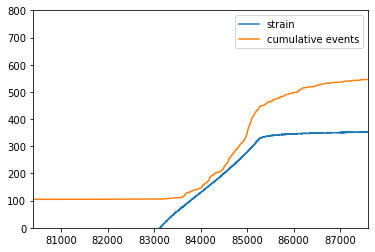

In [38]:
#Zoom in to look for better registration between mechanical and AE data

offset = 101280
tdef_adj = mech_dry_data["t_def"].flatten() - offset

plt.plot(tdef_adj, mech_dry_data["Strain_ax"].flatten()*50000, label="strain")
plt.plot((catalog["datetime"] - catalog.iloc[0]["datetime"])*1e-9, catalog["month"].cumsum(), label="cumulative events")

xmin = 80400
xmax = 87600
plt.xlim((xmin,xmax))
#plt.ylim((mech _dry_data["Strain_ax"].flatten()[xmin:xmax].min()*50000,
#          mech_dry_data["Strain_ax"].flatten()[xmin:xmax].max()*50000))
plt.ylim((0,800))
plt.legend()
plt.show()

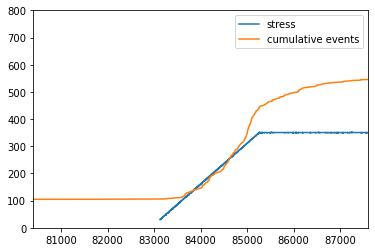

In [41]:
#Now for stress

offset = 101280
tdef_adj = mech_dry_data["t_def"].flatten() - offset

plt.plot(tdef_adj, mech_dry_data["Sig_diff_MPa"].flatten()*5, label="stress")
plt.plot((catalog["datetime"] - catalog.iloc[0]["datetime"])*1e-9, catalog["month"].cumsum(), label="cumulative events")

xmin = 80400
xmax = 87600
plt.xlim((xmin,xmax))
#plt.ylim((mech _dry_data["Strain_ax"].flatten()[xmin:xmax].min()*50000,
#          mech_dry_data["Strain_ax"].flatten()[xmin:xmax].max()*50000))
plt.ylim((0,800))
plt.legend()
plt.show()

In [44]:
# Readjust datasets for the offset
mech_dry_data["t_def"] = tdef_adj
catalog["datetime"] = (catalog["datetime"] - catalog.iloc[0]["datetime"])*1e-9

In [78]:
keys_to_retain = ["t_def","Disp_mm","Sig_diff_MPa","Strain_ax","Temp"]
mech_dry_df = pd.DataFrame({key:mech_dry_data[key].flatten() for key in keys_to_retain})

mech_dry_df["t_def"] = mech_dry_df["t_def"].astype(int)

In [79]:
mech_dry_df.to_csv("../data/processed/dry_mechanical_data.csv")
mech_dry_df.tail()

,t_def,Disp_mm,Sig_diff_MPa,Strain_ax,Temp
431975,589616,5.18593,105.9138,0.047950,80.9728
431976,589617,5.18593,105.9138,0.047950,81.0456
431977,589618,5.18451,105.9138,0.047932,80.9728
431978,589619,5.18451,105.9138,0.047932,81.0092
431979,589620,5.18593,105.5328,0.047950,81.0820


In [80]:
catalog["seconds"] = catalog.datetime.values.astype(int)
dryAE_cat = catalog[["seconds","event_ID","event_ID_orig"]]
dryAE_cat.to_csv("../data/processed/dryAE_cat.csv")
dryAE_cat

,seconds,event_ID,event_ID_orig
0,0,2020.008.393241.142361506,142361506
1,1284,2020.008.395405.143645590,143645590
2,3196,2020.008.402557.145557856,145557856
3,3496,2020.008.403057.145857607,145857607
4,4921,2020.008.405442.147282610,147282610
...,...,...,...
5466,572745,2020.015.1983826.715106760,715106760
5467,574434,2020.015.1990636.716796490,716796490
5468,574437,2020.015.1990638.716798597,716798597
5469,575584,2020.015.1992545.717945520,717945520


In [4]:
dryAE_cat = pd.read_csv("../data/processed/dryAE_cat.csv")
mech_dry_df = pd.read_csv("../data/processed/dry_mechanical_data.csv")

In [5]:
merged_df = dryAE_cat.merge(mech_dry_df,left_on="seconds",right_on="t_def",how="right")
merged_df = merged_df.dropna()
merged_df["events_cumulative"] = merged_df.reset_index().index.values
merged_df

,Unnamed: 0_x,seconds,event_ID,event_ID_orig,Unnamed: 0_y,t_def,Disp_mm,Sig_diff_MPa,Strain_ax,Temp,events_cumulative
51,105.0,83176.0,2020.009.623857.225537977,225537977.0,51,83176,1.50696,7.6197,0.000184,78.2065,0
146,106.0,83271.0,2020.009.624033.225633151,225633151.0,146,83271,1.53385,10.2866,0.000533,78.1337,1
167,107.0,83292.0,2020.009.624053.225653637,225653637.0,167,83292,1.53809,11.0485,0.000588,78.1701,2
292,108.0,83417.0,2020.009.624259.225779480,225779480.0,292,83417,1.56922,14.8584,0.000992,78.1701,3
300,109.0,83425.0,2020.009.624307.225787413,225787413.0,300,83425,1.57205,15.2394,0.001029,78.2065,4
...,...,...,...,...,...,...,...,...,...,...,...
416943,5466.0,572745.0,2020.015.1983826.715106760,715106760.0,415104,572745,5.18451,105.9138,0.047932,80.6453,5130
418632,5467.0,574434.0,2020.015.1990636.716796490,716796490.0,416793,574434,5.18451,105.9138,0.047932,80.6817,5131
418635,5468.0,574437.0,2020.015.1990638.716798597,716798597.0,416796,574437,5.18451,105.9138,0.047932,80.7545,5132
419782,5469.0,575584.0,2020.015.1992545.717945520,717945520.0,417943,575584,5.18451,105.9138,0.047932,80.6817,5133


In [143]:
merged_df.to_csv("../data/processed/dry_events_with_mechdata.csv")

In [6]:
merged_df = pd.read_csv("../data/processed/dry_events_with_mechdata.csv")

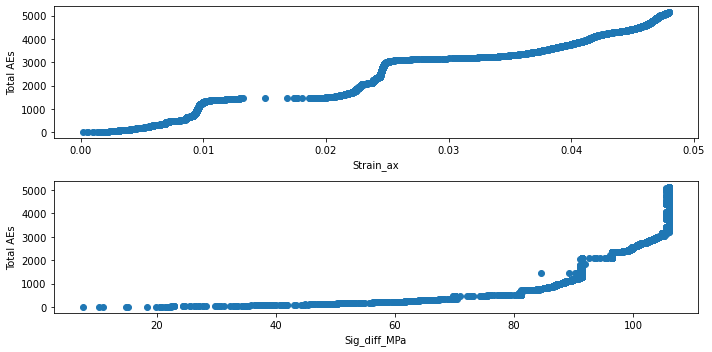

In [7]:
f,axes = plt.subplots(2,1,figsize=(10,5))
depvars = ["Strain_ax", "Sig_diff_MPa"]

for i,depvar in enumerate(depvars):
    axes[i].scatter(merged_df[depvar],merged_df["events_cumulative"])
    axes[i].set_ylabel("Total AEs")
    axes[i].set_xlabel(depvar)
plt.tight_layout()   
plt.show()

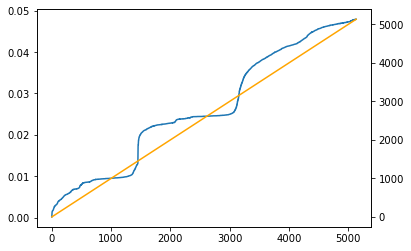

In [502]:
merged_df["Strain_rate"] = merged_df["Strain_ax"].diff().fillna(method="backfill")

#plt.scatter(merged_df["Strain_rate"],merged_df["Sig_diff_MPa"])

f, ax = plt.subplots()
ax.plot(merged_df["Strain_ax"])
ax2 = ax.twinx()
ax2.plot(merged_df["events_cumulative"], 'orange')

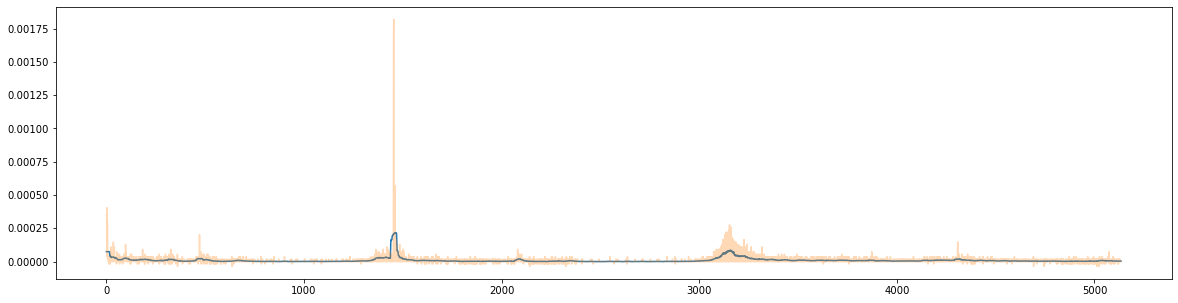

In [503]:
plt.figure(figsize=(20,5))
plt.plot(scipy.signal.savgol_filter(merged_df["Strain_rate"], window_length=31, polyorder=0))
plt.plot(merged_df["Strain_rate"].values,alpha=0.3)

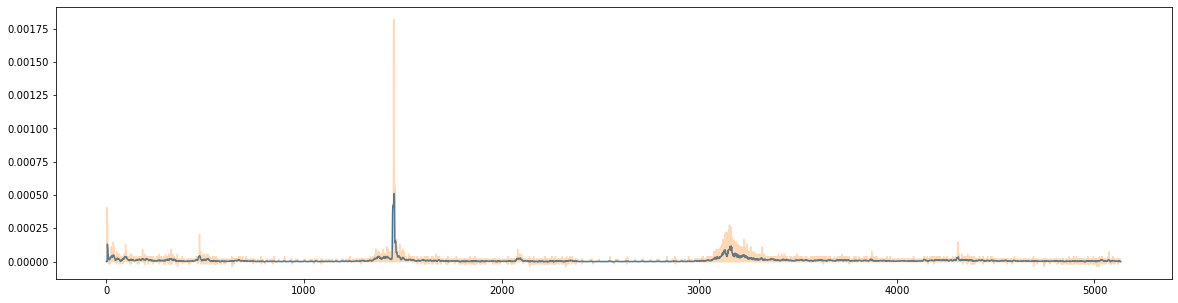

In [504]:
plt.figure(figsize=(20,5))

strain = merged_df["Strain_ax"]

#strain[strain>0.0005] = 0.0005
smoothed_strain = scipy.signal.savgol_filter(strain, window_length=11, polyorder=0)
plt.plot(np.diff(smoothed_strain))
plt.plot(merged_df["Strain_rate"].values,alpha=0.3)

In [126]:
#Create a dictionary of eventnames:waveforms for assoociating stress, strain, time,etc with waveform

print(len(catalog), len(waveforms))
waveform_labelled = {k:v for k,v in list(zip(catalog["event_ID"],waveforms))}

5471 5471


In [505]:
waveform_labelled

{b'2020.008.393241.142361506': array([-12.7356924 , -12.82159908, -13.03149489, ...,   3.10840263,
          2.96027838,   3.05105363]),
 b'2020.008.395405.143645590': array([-4.19698939, -3.27572215, -2.12489601, ...,  0.02904551,
        -1.44263208, -2.55759753]),
 b'2020.008.402557.145557856': array([-40.32237938, -38.32895209, -35.24269419, ...,  -4.31774002,
         -4.60214539,  -4.14585611]),
 b'2020.008.403057.145857607': array([  4.18447656,   4.24217239,   4.97812448, ...,  -5.51859299,
         -8.21790705, -10.41103086]),
 b'2020.008.405442.147282610': array([-7.59986407, -7.38770537, -7.21755911, ..., 24.26307974,
        25.28967702, 26.97317295]),
 b'2020.008.405947.147587333': array([-4.7548429 , -4.50163191, -3.76334098, ...,  3.11697132,
         1.31669948,  0.30877655]),
 b'2020.008.410315.147795121': array([ 1.45335527,  2.06516423,  2.78314114, ...,  1.09898093,
         0.19869388, -1.31134137]),
 b'2020.008.410539.147939479': array([-19.01571712, -20.09580598,

In [507]:
import pickle

with open("../data/processed/labelled_dry_waveforms.pkl","wb") as f:
    pickle.dump(waveform_labelled, f)


# next - normalize waveforms, associate waveform to fingerprint, stress, strain
# then can train some classifiers on the fingerprints to the variables

# also, decimate the waveforms (and/or chop them shoorter to encompass just events) and run the waveforms throough convnet classifier

,b'2020.008.393241.142361506',b'2020.008.395405.143645590',b'2020.008.402557.145557856',b'2020.008.403057.145857607',b'2020.008.405442.147282610',b'2020.008.405947.147587333',b'2020.008.410315.147795121',b'2020.008.410539.147939479',b'2020.008.410542.147942232',b'2020.008.411033.148233238',...,b'2020.015.1951133.702693242',b'2020.015.1953937.704377055',b'2020.015.1963038.707438539',b'2020.015.1973853.711533874',b'2020.015.1974735.712055357',b'2020.015.1983826.715106760',b'2020.015.1990636.716796490',b'2020.015.1990638.716798597',b'2020.015.1992545.717945520',b'2020.015.2005500.723300795'
0,-12.735692,-4.196989,-40.322379,4.184477,-7.599864,-4.754843,1.453355,-19.015717,-7.915199,15.938673,...,26.365686,11.499476,-12.865785,-10.794256,-40.133492,-53.460441,-2.051855,18.660771,9.811515,-35.506307
1,-12.821599,-3.275722,-38.328952,4.242172,-7.387705,-4.501632,2.065164,-20.095806,-8.869219,16.222666,...,27.436799,9.097381,-13.896650,-12.939173,-42.457666,-49.869104,-2.853095,17.272344,7.308439,-35.244955
2,-13.031495,-2.124896,-35.242694,4.978124,-7.217559,-3.763341,2.783141,-20.838390,-10.134596,16.823873,...,28.741056,5.119005,-15.119159,-15.647130,-45.947563,-44.112210,-4.235793,14.812844,3.665681,-33.915608
3,-13.825761,-2.869947,-32.663458,7.085348,-6.687836,-1.993348,1.904045,-18.959975,-9.901442,18.004503,...,29.243415,1.965158,-14.084555,-15.878106,-48.538664,-40.048220,-5.881100,11.716340,0.864987,-31.226691
4,-14.519680,-4.261929,-30.643777,9.635315,-6.472468,0.144169,0.751241,-16.183363,-9.095008,19.218768,...,29.254219,-1.258860,-12.404318,-15.112132,-50.593072,-36.612769,-7.699742,8.546636,-1.749052,-27.877704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32760,5.067746,2.115327,-0.525719,-2.476293,26.615336,8.213009,-0.686272,5.296840,2.426983,-39.407591,...,-16.231456,-11.551539,-106.924134,-13.612937,-12.513559,-74.318165,-30.569039,-1.522905,33.231974,-21.803947
32761,3.777961,1.090538,-2.347263,-3.852531,25.647252,5.509717,-0.249468,4.134654,2.325898,-40.513107,...,-11.652923,-10.401277,-104.680620,-16.978337,-13.347465,-69.926286,-32.676063,-2.499365,34.997574,-21.780395
32762,3.108403,0.029046,-4.317740,-5.518593,24.263080,3.116971,1.098981,2.551014,1.627809,-41.879111,...,-7.181946,-9.419276,-101.641914,-19.263432,-14.140999,-65.900264,-34.741950,-4.074623,37.094061,-21.363872
32763,2.960278,-1.442632,-4.602145,-8.217907,25.289677,1.316699,0.198694,3.534137,2.357928,-40.224211,...,-4.624515,-8.140464,-97.357244,-20.673159,-15.261087,-59.984836,-36.448648,-6.619072,36.686995,-23.212782


In [139]:
# Prep sepctrograms

sgrams = {}
with h5py.File(drypath+"data_Dry_AEs.h5_Sgrams_Subcatalog.hdf5") as f:
    print(f.keys())

<KeysViewHDF5 ['sgram_normConst', 'sgrams']>


In [142]:
with h5py.File("/Volumes/T7/datasets/MIT_AE/specufex_results.h5") as f:
    print(f.keys())
    print(len(f["As"]))

<KeysViewHDF5 ['As', 'Ppis', 'Vs', 'fprints', 'gams']>
17481


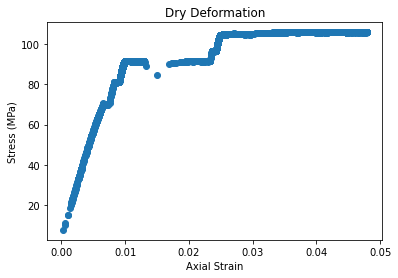

In [121]:
plt.scatter(merged_df["Strain_ax"],merged_df["Sig_diff_MPa"])
plt.ylabel("Stress (MPa)")
plt.xlabel(("Axial Strain"))
plt.title("Dry Deformation")
plt.show()

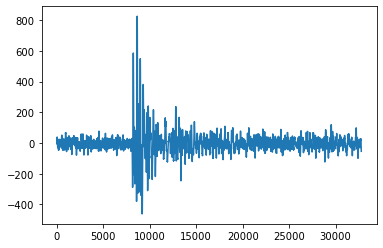

In [154]:
plt.plot(waveforms[5002])

In [74]:
len(waveforms)

5471

In [87]:
pd.to_datetime(mech_dry_data["t_def"].astype(int).flatten(), unit="s")

DatetimeIndex(['1970-01-03 03:13:25', '1970-01-03 03:13:26',
               '1970-01-03 03:13:27', '1970-01-03 03:13:28',
               '1970-01-03 03:13:29', '1970-01-03 03:13:30',
               '1970-01-03 03:13:31', '1970-01-03 03:13:32',
               '1970-01-03 03:13:33', '1970-01-03 03:13:34',
               ...
               '1970-01-08 23:54:51', '1970-01-08 23:54:52',
               '1970-01-08 23:54:53', '1970-01-08 23:54:54',
               '1970-01-08 23:54:55', '1970-01-08 23:54:56',
               '1970-01-08 23:54:57', '1970-01-08 23:54:58',
               '1970-01-08 23:54:59', '1970-01-08 23:55:00'],
              dtype='datetime64[ns]', length=431980, freq=None)

In [118]:
wet_waveforms = []
wet_catalog = pd.DataFrame()

with h5py.File(os.path.join(wetpath, "MIT_NER_idWater_ch01-001.h5")) as f:
    print(f.keys())
    #print(f["catalog"].keys())
    for key in f["catalog"].keys():
        wet_catalog[key] = f[f"catalog/{key}"][()]
    #print(f["catalog/datetime"])
    #print(f["waveforms/pzt01/01"].keys())
    wet_evids = list(f["waveforms/pzt01/01"].keys())
    for id in wet_evids:
        wet_waveforms.append(f[f"waveforms/pzt01/01/{id}"][()])

<KeysViewHDF5 ['catalog', 'processing_info', 'spec_parameters', 'waveforms']>


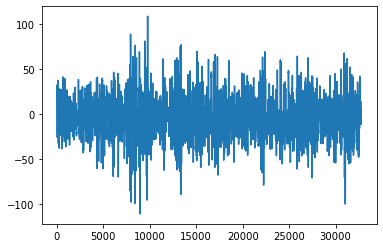

In [124]:
plt.plot(wet_waveforms[400])

In [131]:
from scipy.signal import sosfilt, zpk2sos, iirfilter,welch, decimate

# swiped from obspy codebase



def lowpass(data, freq, df, corners=4, zerophase=False):
    """
    Butterworth-Lowpass Filter.
    Filter data removing data over certain frequency ``freq`` using ``corners``
    corners.
    The filter uses :func:`scipy.signal.iirfilter` (for design)
    and :func:`scipy.signal.sosfilt` (for applying the filter).
    :type data: numpy.ndarray
    :param data: Data to filter.
    :param freq: Filter corner frequency.
    :param df: Sampling rate in Hz.
    :param corners: Filter corners / order.
    :param zerophase: If True, apply filter once forwards and once backwards.
        This results in twice the number of corners but zero phase shift in
        the resulting filtered trace.
    :return: Filtered data.
    """
    fe = 0.5 * df
    f = freq / fe
    # raise for some bad scenarios
    if f > 1:
        f = 1.0
        msg = "Selected corner frequency is above Nyquist. " + \
              "Setting Nyquist as high corner."
        print(msg)
    z, p, k = iirfilter(corners, f, btype='lowpass', ftype='butter',
                        output='zpk')
    sos = zpk2sos(z, p, k)
    if zerophase:
        firstpass = sosfilt(sos, data)
        return sosfilt(sos, firstpass[::-1])[::-1]
    else:
        return sosfilt(sos, data)

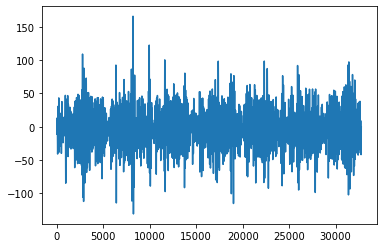

In [153]:
plt.plot(lowpass(wet_waveforms[8100],0.1,1,zerophase=True))

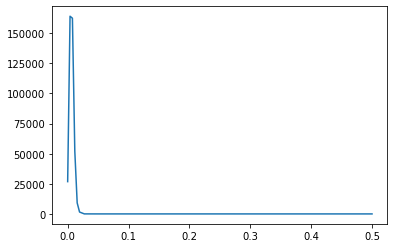

In [163]:
plt.plot(*welch(waveforms[2]))

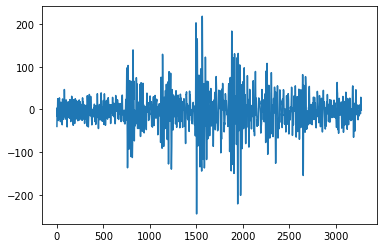

In [165]:
plt.plot(decimate(waveforms[2], 10))

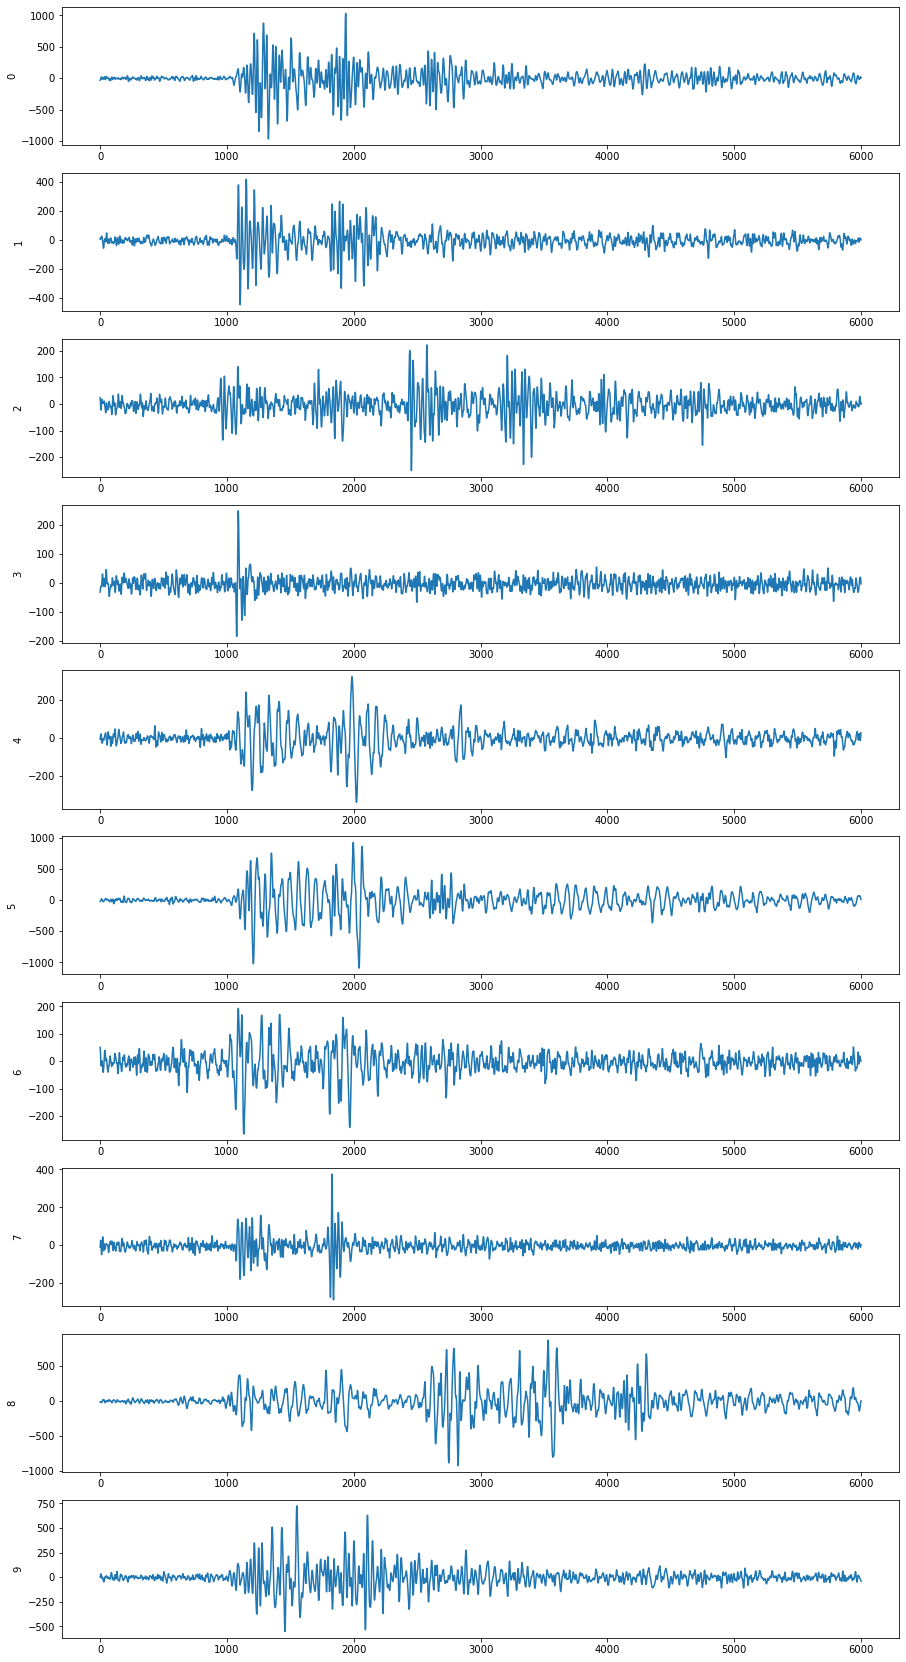

In [232]:
N = 10

f,axes = plt.subplots(N,1,figsize=(15,N*3))

decimate_wave = True

for i in range(N):
    if decimate_wave:
        wave = decimate(waveforms[i][2765:], 5)
    else:
        wave = waveforms[i]
    axes[i].plot(wave)
    axes[i].set_ylabel(i)

NameError: name 'wet_waveforms' is not defined

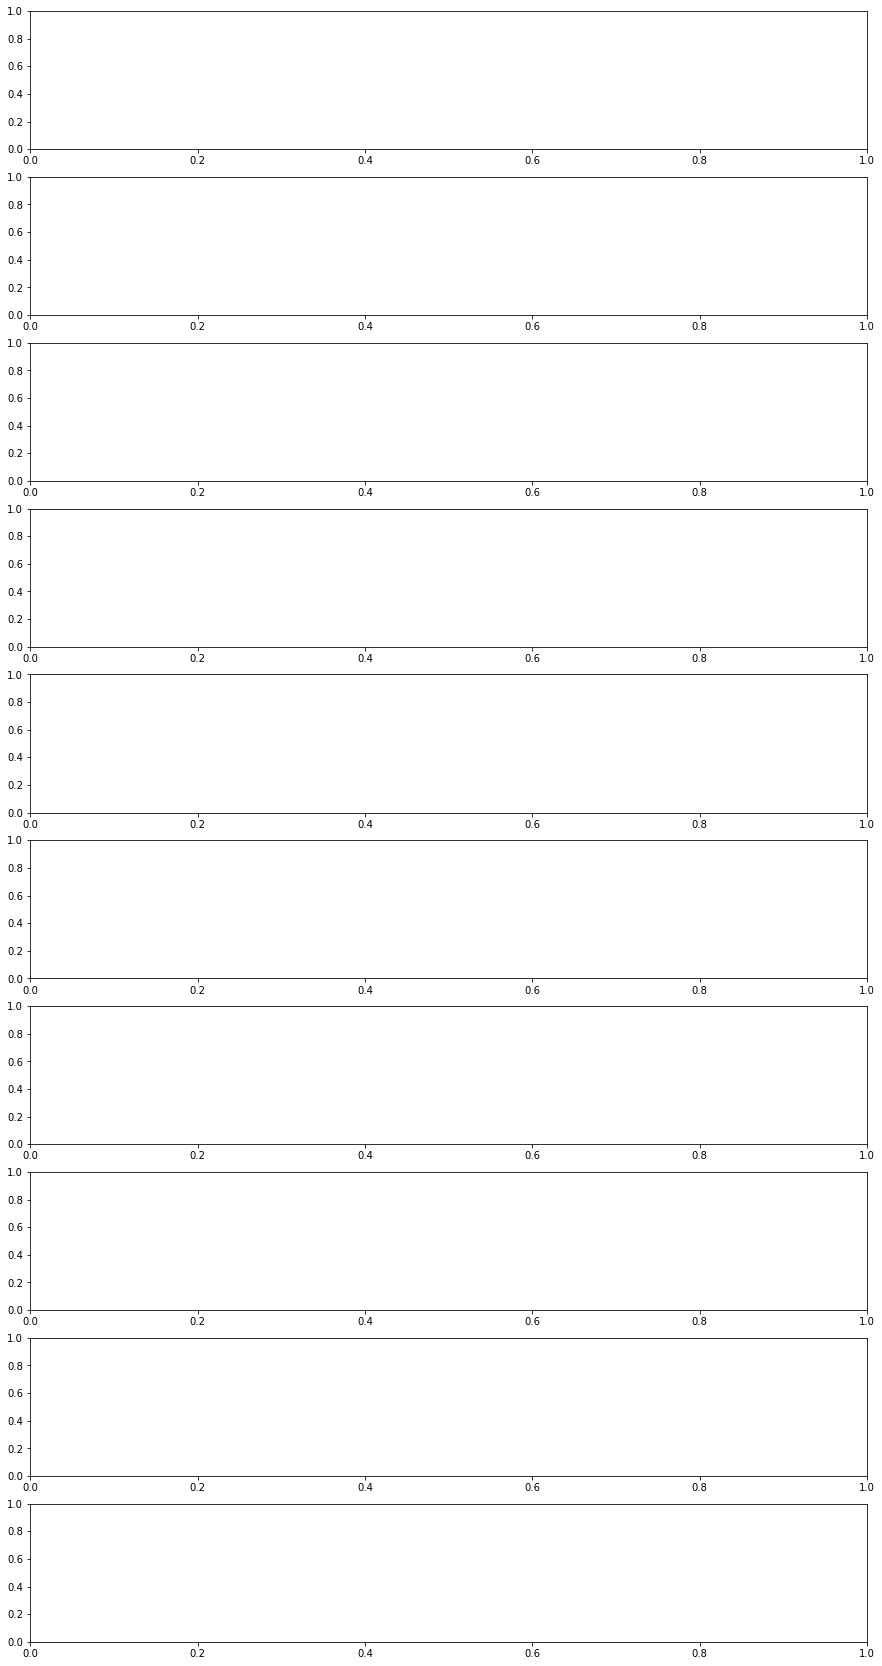

In [233]:
N = 10

f,axes = plt.subplots(N,1,figsize=(15,N*3))

for i in range(N):
    axes[i].plot(decimate(decimate(wet_waveforms[i],10),10))

In [148]:
waveforms[0].shape

(32765,)

In [171]:
from scipy import signal

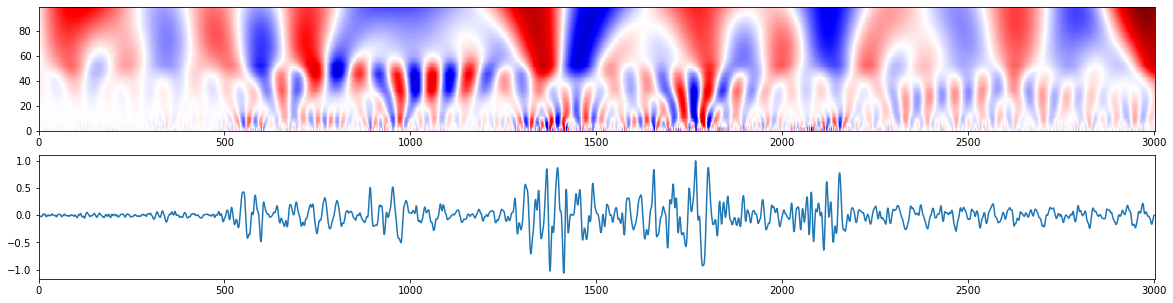

In [331]:
wave = decimate(waveforms[8][2750:],10)
wave=wave/np.max(wave)

cwtmat = signal.cwt(wave, signal.wavelets.ricker, widths=np.arange(1,100))
cwtmat /= cwtmat.max(axis=1)[:,np.newaxis]
#cwtmat = np.log(np.abs(cwtmat))
#cwtmat = cwtmat[::5]
#plt.figure(figsize=(20,5))

f, axes = plt.subplots(2,1,figsize=(20,5))
axes[0].pcolormesh(cwtmat, cmap='seismic_r',
           vmax=abs(cwtmat).max(), vmin=-abs(cwtmat).max())
axes[1].plot(wave)
axes[1].set_xlim([0, len(wave)])
plt.show()

In [348]:
from IPython.display import Audio
from scipy.io import wavfile
import scipy

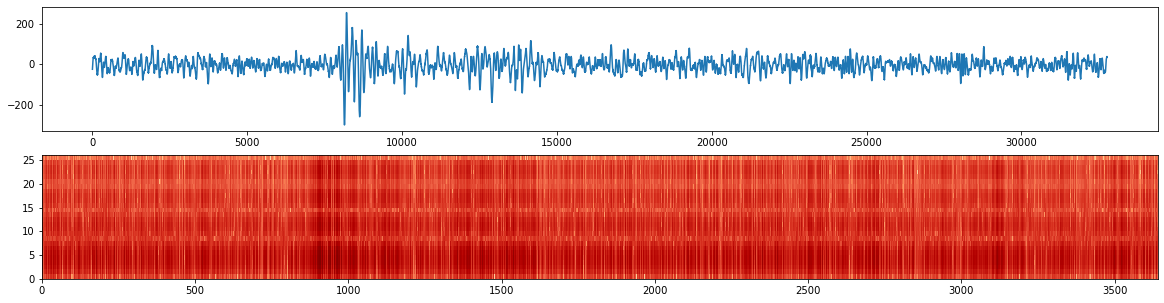

In [390]:
i = 5003
#wavfile.write(f"../data/audio/waveform{i}.wav", 8000, waveforms[i])

f, axes = plt.subplots(2,1,figsize=(20,5))
axes[0].plot(waveforms[i])
spect = scipy.signal.spectrogram(waveforms[i], nperseg=10, nfft=50)[-1]
axes[1].pcolormesh(np.log(spect), cmap="OrRd")

(0.0, 3002.0)

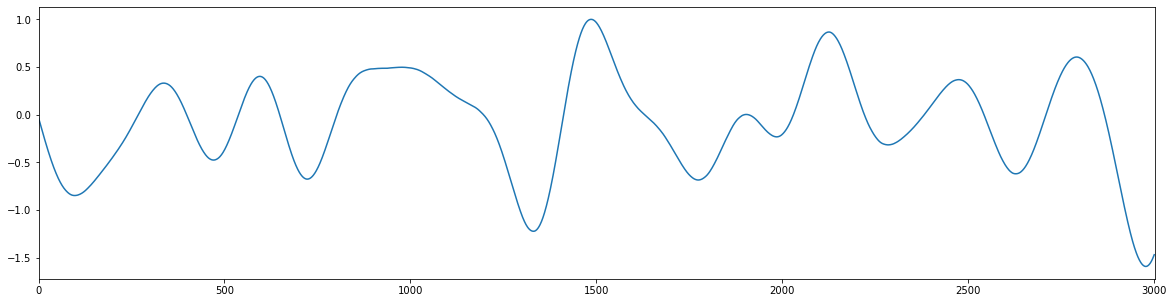

In [329]:
plt.figure(figsize=(20,5))
plt.plot(cwtmat[-6,:])
plt.xlim([0, len(wave)])

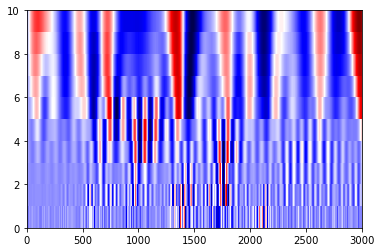

In [549]:
tmp = cwtmat/cwtmat.max(axis=1)[:,np.newaxis]
#plt.pcolormesh(tmp[(0,1,2,4,8,16,32,64, 90),:], cmap="seismic_r")
#plt.pcolormesh(tmp, cmap="seismic_r")
plt.pcolormesh(tmp[::10,:], cmap="seismic_r")

# Prep data for the waveform CNN training

Trim and decimate to 6000 samples.

Save waveforms in order of events 

Save mechanical data in dataframe in order of events (or dict of arrays?)

In [6]:

with open("../data/processed/labelled_dry_waveforms.pkl", "rb") as f:
    dry_waves = pickle.load(f)

In [7]:
dry_waves_keys = dry_waves.keys()
dry_waves_keys = [x.decode("utf-8") for x in dry_waves_keys]
dry_waves_waves = dry_waves.values()

In [10]:
dry_wave_df = pd.DataFrame({"eventid":dry_waves_keys, "waveform":dry_waves_waves})

waves = merged_df.merge(dry_wave_df, left_on="event_ID", right_on="eventid", how="left")["waveform"]

In [13]:
processed_waves = []

for wave in waves:
    wave = decimate(wave[2765:], 5)
    #normailze
    processed_waves.append(wave/np.max(np.abs(wave)))


processed_waves = np.vstack(processed_waves)

processed_waves.shape

(5135, 6000)

In [533]:
np.save("../data/processed/dry_waves.npy",processed_waves)

In [531]:
processed_waves

array([[ 7.79871633, 12.55864501, 15.78395974, ...,  8.48842245,
         5.5958052 ,  2.06952587],
       [ 7.79871633, 12.55864501, 15.78395974, ...,  8.48842245,
         5.5958052 ,  2.06952587],
       [ 7.79871633, 12.55864501, 15.78395974, ...,  8.48842245,
         5.5958052 ,  2.06952587],
       ...,
       [ 7.79871633, 12.55864501, 15.78395974, ...,  8.48842245,
         5.5958052 ,  2.06952587],
       [ 7.79871633, 12.55864501, 15.78395974, ...,  8.48842245,
         5.5958052 ,  2.06952587],
       [ 7.79871633, 12.55864501, 15.78395974, ...,  8.48842245,
         5.5958052 ,  2.06952587]])

In [536]:
from sklearn.preprocessing import scale

scaled_stress = scale(merged_df.Sig_diff_MPa.values)
scaled_strain = scale(merged_df.Strain_ax.values)

In [539]:
scaled_strain

array([-1.84230195, -1.81773569, -1.81386209, ...,  1.51744771,
        1.51744771,  1.51744771])

# Now do continuos wavelet transform


In [24]:
from scipy import signal

wavelets = []

for wave in processed_waves:
    # decimate to have the length
    wave = decimate(wave,2)
    cwtmat = signal.cwt(wave, signal.wavelets.ricker, widths=np.arange(1,100))
    cwtmat /= cwtmat.max(axis=1)[:,np.newaxis]
    cwtmat = cwtmat[::10,:].T

    wavelets.append(cwtmat.astype(np.float32))

wavelets = np.stack(wavelets)

wavelets.shape

TypeError: list indices must be integers or slices, not tuple

In [31]:
wavelets  = np.stack(wavelets)
wavelets.shape

(5135, 3000, 10)

In [32]:
np.save("../data/processed/dry_cwt.npy", wavelets)

In [ ]:
eqt.layers[2].input = x


NameError: name 'x' is not defined

In [38]:
(wavelets/wavelets.max(axis=1)[:,np.newaxis,:]).shape

(5135, 3000, 10)

In [39]:
wavelets.max(axis=1)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [40]:
np.max(wavelets)

1.0

# Make a strain rate data series

It's very noisy, need to smoooth and then take derivative

<AxesSubplot:>

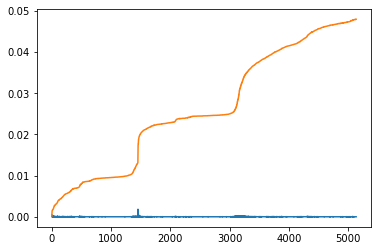

In [43]:
merged_df["Strain_ax"].plot()

<AxesSubplot:>

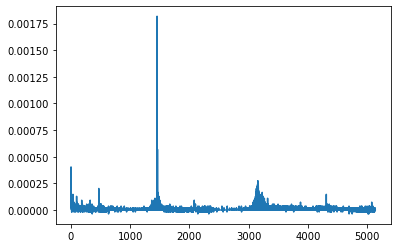

In [44]:
merged_df["Strain_ax"].diff().plot()

In [45]:
from scipy import interpolate

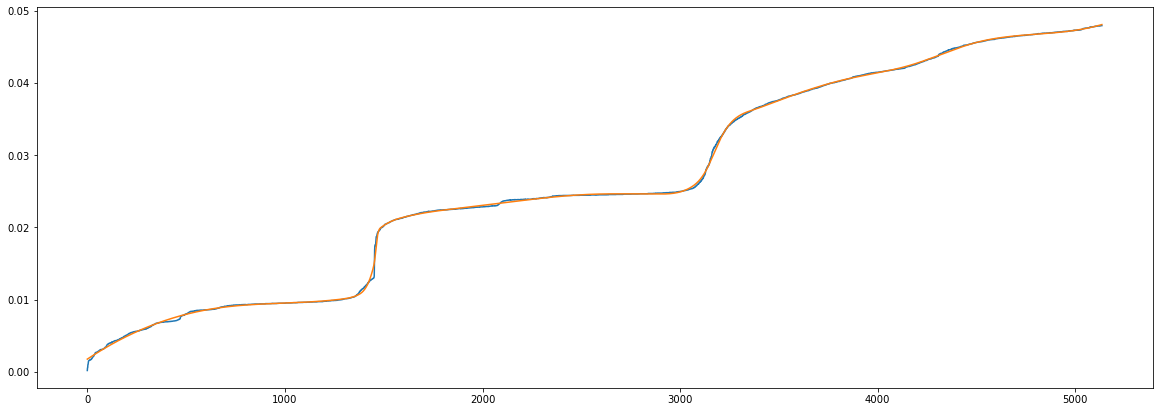

In [120]:
xs = np.arange(len(merged_df["Strain_ax"]))
ys = merged_df["Strain_ax"].values

tck = interpolate.splrep(xs, ys, s=0.00015)
ynew = interpolate.splev(xs, tck, der=0)

plt.figure(figsize=(20,7))
plt.plot(ys)
plt.plot(ynew)

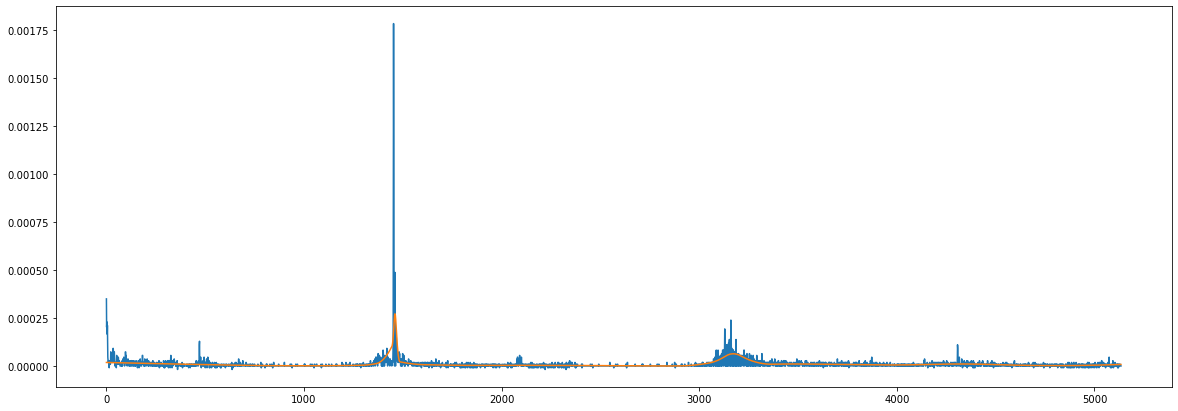

In [121]:
plt.figure(figsize=(20,7))
plt.plot(np.gradient(ys))
strate = interpolate.splev(xs, tck, der=1)
strate = np.maximum(0, strate) # replace negative values with 0
plt.plot(strate)

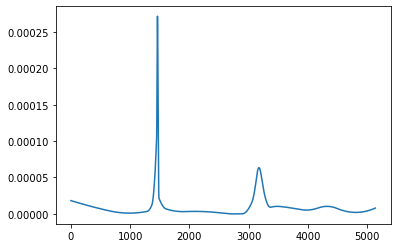

In [122]:
plt.plot(strate)

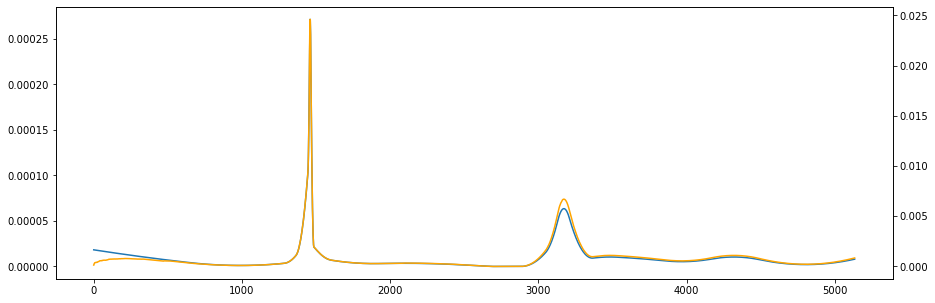

In [123]:
f,ax = plt.subplots(figsize=(15,5))

ax.plot(strate)
ax2 = ax.twinx()
ax2.plot(strate*merged_df["Sig_diff_MPa"].values, c='orange')

/var/folders/sw/v_c5zhcj1pd1x3tf08pwljx00000gn/T/ipykernel_36891/2453895133.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(merged_df["Sig_diff_MPa"].values, np.log10(strate))


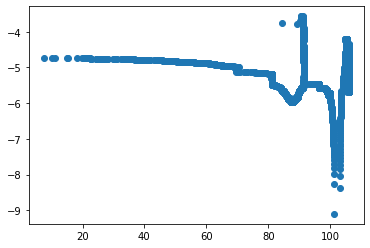

In [128]:
plt.scatter(merged_df["Sig_diff_MPa"].values, np.log10(strate))

In [129]:
np.save("../data/processed/dry_strate.npy", strate)


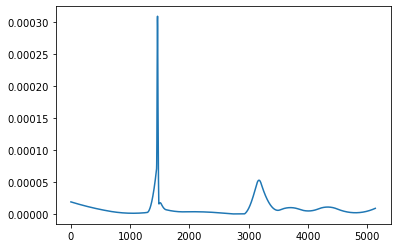

In [117]:
plt.plot(np.maximum(0, strate))

# Bin data for classification problem

By binning data into stress or strain ranges and using a classifier instead of a regression model, we can create probability distributions for the predictions.

In [8]:
merged_df

,Unnamed: 0,seconds,event_ID,event_ID_orig,t_def,Disp_mm,Sig_diff_MPa,Strain_ax,Temp,events_cumulative
0,51,83176.0,2020.009.623857.225537977,225537977,83176,1.50696,7.6197,0.000184,78.2065,0
1,146,83271.0,2020.009.624033.225633151,225633151,83271,1.53385,10.2866,0.000533,78.1337,1
2,167,83292.0,2020.009.624053.225653637,225653637,83292,1.53809,11.0485,0.000588,78.1701,2
3,292,83417.0,2020.009.624259.225779480,225779480,83417,1.56922,14.8584,0.000992,78.1701,3
4,300,83425.0,2020.009.624307.225787413,225787413,83425,1.57205,15.2394,0.001029,78.2065,4
...,...,...,...,...,...,...,...,...,...,...
5130,416943,572745.0,2020.015.1983826.715106760,715106760,572745,5.18451,105.9138,0.047932,80.6453,5130
5131,418632,574434.0,2020.015.1990636.716796490,716796490,574434,5.18451,105.9138,0.047932,80.6817,5131
5132,418635,574437.0,2020.015.1990638.716798597,716798597,574437,5.18451,105.9138,0.047932,80.7545,5132
5133,419782,575584.0,2020.015.1992545.717945520,717945520,575584,5.18451,105.9138,0.047932,80.6817,5133


<AxesSubplot:>

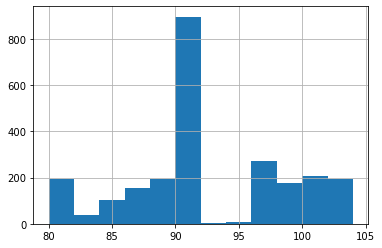

In [29]:
merged_df.Sig_diff_MPa.hist(bins=range(80,105,2))

In [20]:
np.histogram(merged_df.Sig_diff_MPa.values, bins=[0,50,80,90,95,100])

(array([141, 372, 683, 900, 452]), array([  0,  50,  80,  90,  95, 100]))

In [39]:
stress_bins = pd.cut(merged_df.Sig_diff_MPa, bins=[0,80,90,95,100,110], labels=[0,1,2,3,4]).values

In [40]:
np.save("../data/processed/dry_stress_bins.npy", stress_bins)

In [36]:
merged_df['Strain_rate'] = np.load("../data/processed/dry_strate.npy")

<AxesSubplot:>

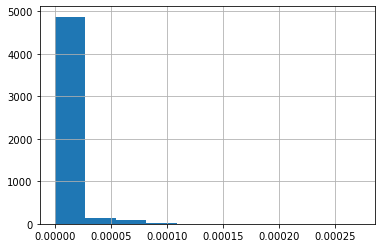

In [38]:
merged_df.Strain_rate.hist()